In [1]:
import copy

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#计算特征值模块
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# 机器学习模块
from sklearn import model_selection
from sklearn.linear_model import Lasso,LassoCV
from sklearn.metrics import mean_squared_error
# 使用lasso直接进行建模
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler


# 随机森林模块
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
#实现图片的交互
# %matplotlib

#套用网站的九种理化性质计算出来，将序列分成三段，计算相关性，使用lasso进行回归预测，使用随机森林进行预测
#计算靠近的四个端点的理化性质


In [2]:
######设置工作路径并读入文件#########
os.chdir(r'E:\文件\大学课程\大四上\毕业设计\数据分析\ninthweek')
df=pd.read_excel('all-peptides-pairs.xlsx',header=0)

#######样本选择#########
#N端无修饰，C端有无酰胺化修饰
testdf=df[(df['stick_terminal']=='n_terminal') & (df['communal-modification']=='none') & (df['modification2']=='AMD')]
#固定C端为AMD时，N端有无乙酰化修饰
# testdf=df[(df['stick_terminal']=='c_terminal') & (df['communal-modification']=='AMD') & (df['modification2']=='ACT')]
#筛选出LIPID_SAMPLE1
# testdf=df[(df['modification2'].isin(['C3', 'C4', 'C5','C6','C7','C8','C10','C11','C12','C13','C14','C15','C16','C18','C19','C20'])) & (df['communal-modification']=='AMD') & (df['stick_terminal']=='c_terminal')].copy()
#筛选出LIPID_SAMPLE2
# testdf=df[(df['modification2'].isin(['C3', 'C4', 'C5','C6','C7','C8','C10','C11','C12','C13','C14','C15','C16','C18','C19','C20'])) & (df['communal-modification']=='none') & (df['stick_terminal']=='c_terminal')].copy()


#####对数据进一步筛选#########
testdf = testdf[~testdf['sequence'].str.contains('[a-z]')]      #把构象不同的氨基酸筛掉
testdf = testdf[~testdf['sequence'].str.contains('X')]          #把非常规氨基酸筛掉
df_filtered = testdf[testdf['sequence'].str.len() >= 6]          #保证序列长度大于等于4
df_filtered=df_filtered[df_filtered['fold-change']!=0]
# df_filtered=df_filtered[(df_filtered['fold-change']>=1) | (df_filtered['fold-change']<=-1)]
# df_filtered.to_excel('df_filtered.xlsx',index=False)

In [3]:
df_filtered

,sequence,target,stick_terminal,communal-modification,measure,unit,modification1,modification2,activity1,activity2,fold-change,abs(none-modification)
0,ALWKTLLKKVLKA,Staphylococcus aureus B38302,n_terminal,none,MIC,uM,none,AMD,3.00,9.00,-1.584963,6.00
1,ALWKTLLKKVLKA,Escherichia coli U16318,n_terminal,none,MIC,uM,none,AMD,6.00,4.50,0.415037,1.50
5,KKLFKKILKYL,Xanthomonas campestris pv. Vesicatoria 2133-2,n_terminal,none,MIC,uM,none,AMD,15.00,4.65,1.689660,10.35
6,KKLFKKILKYL,Pseudomonas syringae pv. syringae EPS 94,n_terminal,none,MIC,uM,none,AMD,8.75,4.65,0.912052,4.10
7,KKLFKKILKYL,Erwinia amylovora PMV 6076,n_terminal,none,MIC,uM,none,AMD,8.75,4.65,0.912052,4.10
...,...,...,...,...,...,...,...,...,...,...,...,...
3104,TQQAFQKFLAAVTSALGKQYH,Aeromonas hydrophila KCTC 2358,n_terminal,none,MEC,ug/ml,none,AMD,125.00,8.80,3.828281,116.20
3105,TQQAFQKFLAAVTSALGKQYH,Streptococcus iniae FP5229,n_terminal,none,MEC,ug/ml,none,AMD,23.00,4.40,2.386058,18.60
3107,TQQAFQKFLAAVTSALGKQYH,Vibrio parahaemolyticus KCCM 41664,n_terminal,none,MEC,ug/ml,none,AMD,1.50,1.70,-0.180572,0.20
3108,TQQAFQKFLAAVTSALGKQYH,Candida albicans KCTC 7965,n_terminal,none,MEC,ug/ml,none,AMD,12.00,6.20,0.952694,5.80


In [4]:
#创建10个位点3中理化性质计算的函数（计算30个特征对应的特征值）
def Hydrophobicity(seq,index):
    single=['1','2','0','-1','-2','-3']
    if index in single:
        new_index=int(index)
        protein = ProteinAnalysis(seq[new_index])
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='full':
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='start':
        length=len(seq)//3
        seq=seq[:length]
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='end':
        length=len(seq)//3
        seq=seq[-length:]
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='middle':
        length=len(seq)//3
        seq=seq[length:-length]
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
def PI(seq,index):
    single=['1','2','0','-1','-2','-3']
    if index in single:
        new_index=int(index)
        protein = ProteinAnalysis(seq[new_index])
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='full':
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='start':
        length=len(seq)//3
        seq=seq[:length]
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='end':
        length=len(seq)//3
        seq=seq[-length:]
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='middle':
        length=len(seq)//3
        seq=seq[length:-length]
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
def Charge(seq,index):
    single=['1','2','0','-1','-2','-3']
    if index in single:
        new_index=int(index)
        protein = ProteinAnalysis(seq[new_index])
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='full':
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='start':
        length=len(seq)//3
        seq=seq[:length]
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='end':
        length=len(seq)//3
        seq=seq[-length:]
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='middle':
        length=len(seq)//3
        seq=seq[length:-length]
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge

In [5]:
# 计算30个特征值
df_attributes=pd.DataFrame()
P_list=['Charge','Hydrophobicity','PI']
types=['0','1','2','-1','-2','-3','full','start','middle','end']
# a_list
for i in types:
    for j in P_list:
        colname='&'.join([i,j])
        if j=='Charge':
            df_attributes[colname]=df_filtered['sequence'].apply(Charge,args=(i,))
        elif j=='Hydrophobicity':
            df_attributes[colname]=df_filtered['sequence'].apply(Hydrophobicity,args=(i,))
        else:
            df_attributes[colname]=df_filtered['sequence'].apply(PI,args=(i,))


In [6]:
#把特征和变量放入一个文件
all_df=copy.deepcopy(df_attributes)
all_df['fold-change']=copy.deepcopy(df_filtered['fold-change'])
all_df

,0&Charge,0&Hydrophobicity,0&PI,1&Charge,1&Hydrophobicity,1&PI,2&Charge,2&Hydrophobicity,2&PI,-1&Charge,...,start&Charge,start&Hydrophobicity,start&PI,middle&Charge,middle&Hydrophobicity,middle&PI,end&Charge,end&Hydrophobicity,end&PI,fold-change
0,-0.204125,1.8,5.570017,-0.239898,3.8,5.525000,-0.239898,-0.9,5.525000,-0.204125,...,0.794876,0.200000,8.795051,1.396199,-0.180000,10.000545,0.732989,1.475000,8.720010,-1.584963
1,-0.204125,1.8,5.570017,-0.239898,3.8,5.525000,-0.239898,-0.9,5.525000,-0.204125,...,0.794876,0.200000,8.795051,1.396199,-0.180000,10.000545,0.732989,1.475000,8.720010,0.415037
5,0.759103,-3.9,8.750052,0.759103,-3.9,8.750052,-0.239898,3.8,5.525000,-0.239898,...,1.758104,-1.333333,10.002737,1.758104,0.660000,10.002737,0.758104,-0.466667,8.590880,1.689660
6,0.759103,-3.9,8.750052,0.759103,-3.9,8.750052,-0.239898,3.8,5.525000,-0.239898,...,1.758104,-1.333333,10.002737,1.758104,0.660000,10.002737,0.758104,-0.466667,8.590880,0.912052
7,0.759103,-3.9,8.750052,0.759103,-3.9,8.750052,-0.239898,3.8,5.525000,-0.239898,...,1.758104,-1.333333,10.002737,1.758104,0.660000,10.002737,0.758104,-0.466667,8.590880,0.912052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104,-0.601803,-0.7,5.184989,-0.239898,-3.5,5.525000,-0.239898,-3.5,5.525000,-0.152724,...,0.397198,-1.500000,8.410110,-0.239898,1.842857,5.525000,0.881051,-0.957143,8.641036,3.828281
3105,-0.601803,-0.7,5.184989,-0.239898,-3.5,5.525000,-0.239898,-3.5,5.525000,-0.152724,...,0.397198,-1.500000,8.410110,-0.239898,1.842857,5.525000,0.881051,-0.957143,8.641036,2.386058
3107,-0.601803,-0.7,5.184989,-0.239898,-3.5,5.525000,-0.239898,-3.5,5.525000,-0.152724,...,0.397198,-1.500000,8.410110,-0.239898,1.842857,5.525000,0.881051,-0.957143,8.641036,-0.180572
3108,-0.601803,-0.7,5.184989,-0.239898,-3.5,5.525000,-0.239898,-3.5,5.525000,-0.152724,...,0.397198,-1.500000,8.410110,-0.239898,1.842857,5.525000,0.881051,-0.957143,8.641036,0.952694


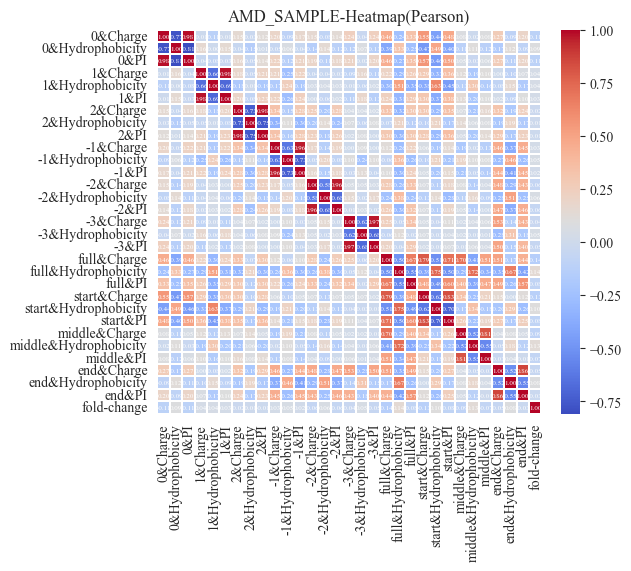

In [14]:
#绘制相关性热图
corr=all_df.corr(method='pearson')
plt.figure(figsize=(8,6), facecolor='w') # 底色white
cor_map = sns.heatmap(corr, square=True, annot=True, fmt='.2f',
                 linewidth=0.1, cmap='coolwarm',linecolor='white', cbar=True,
                 annot_kws={'size':5,'weight':'normal','color':'white'},
                 cbar_kws={'fraction':0.046, 'pad':0.03})
plt.rcParams['font.sans-serif']= ['Times New Roman']    # 设置字体
plt.title('AMD_SAMPLE-Heatmap(Pearson)')
# plt.xticks(rotation=45)  # x轴的标签旋转90度
# plt.yticks(fontsize=8)
plt.subplots_adjust(bottom=0.3,left=0.1,right=0.9,top=0.94)
plt.savefig(r"E:\文件\大学课程\大四上\毕业设计\数据分析\ninthweek\建模\AMD_corr_heatmap.png", dpi=800)

Lasso回归

In [7]:
# lasso模型回归
#筛选出

# 读取数据
lasso_model = copy.deepcopy(all_df)  #原始文件改变需要调这里，切记这个原始文件是所有特征和fold-change合在一起了
# 分离特征和因变量
X_lasso = lasso_model.drop('fold-change', axis=1)
y_lasso = lasso_model['fold-change']
# 数据标准化
scaler = StandardScaler()
X_lasso = scaler.fit_transform(X_lasso)
# 划分训练集和测试集
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=0.1, random_state=42)


#创建正则化系数范围
Lambdas = np.logspace(-5, 2, 200)    #10的-5到10的2次方
# 构造空列表，用于存储模型的偏回归系数
lasso_cofficients = []
#构造空列表，添加均方差和拟合度
lasso_mse=[]
lasso_r2=[]
mse_and_r2=[]
for Lambda in Lambdas:
    model = Lasso(alpha = Lambda,max_iter=10000)  #设置模型的正则化强度
    model.fit(X_train_lasso, y_train_lasso)   #对模型进行拟合
    lasso_cofficients.append(model.coef_)    #获取模型对应的特征系数对应的数列
    mse_scores = -cross_val_score(model, X_train_lasso, y_train_lasso, cv=10, scoring='neg_mean_squared_error')       #计算交叉验证情况下模型的所有均方差
    mse_score=np.mean(mse_scores)   #计算平均的均方差
    lasso_mse.append(mse_score)  #将均方差加入列表中
    scores = cross_val_score(model, X_train_lasso, y_train_lasso, cv=10)  #计算该参数下交叉验证模型中的所有拟合度
    score = np.mean(scores)   #计算获取交叉验证中拟合度的均值
    lasso_r2.append(score)
    mse_and_r2.append((mse_score,score))     #将交叉验证获得的平均均方差和拟合度添加到一个二维数组的列表中


C:\Users\lanliu\AppData\Local\Temp\ipykernel_14240\2444608669.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


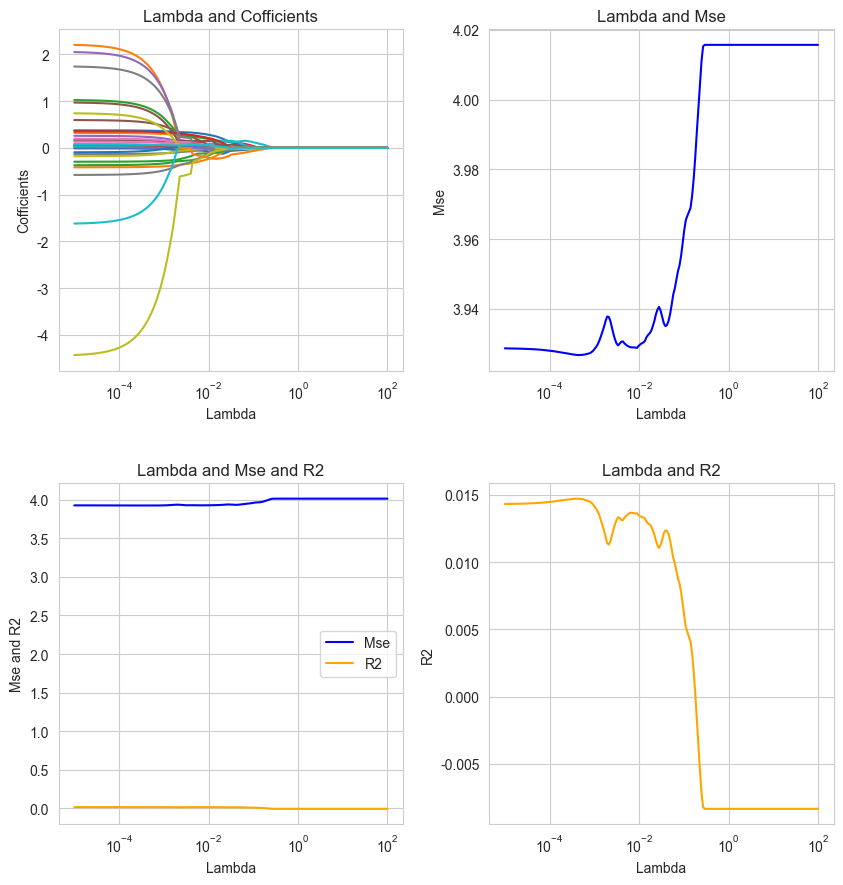

In [8]:
# %matplotlib inline
# %matplotlib
##将四个图画在一起
plt.figure(figsize=(10,10))
# 关闭网格线
# plt.rcParams['axes.grid'] = False
# 设置全局字体样式
plt.rcParams["font.family"] = "Arial"   #设置该字体可以解决横纵坐标负号无法显示的问题
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
plt.axis('on')

#绘制正则化系数和特征系数图
plt.subplot(2,2,1)
# 绘制Lambda与回归系数的关系
plt.plot(Lambdas, lasso_cofficients)
# 对x轴作对数变换
x_ticks = np.logspace(-4, 2, 7)
plt.xticks(x_ticks, x_ticks)
plt.xscale('log')
# 设置折线图x轴和y轴标签
plt.xlabel('Lambda')
plt.ylabel('Cofficients')
#设置图表标题
plt.title('Lambda and Cofficients')

# 绘制正则化系数、均方误差和拟合度
plt.subplot(2,2,3)
# 绘制Lambda与回归系数的关系
# plt.plot(Lambdas, mse_and_r2)
plt.plot(Lambdas,lasso_mse,color='blue',label='Mse')
plt.plot(Lambdas,lasso_r2,color='orange',label='R2')
#添加图例
plt.legend()
# 对x轴作对数变换
plt.xscale('log')
# 设置折线图x轴和y轴标签
plt.xlabel('Lambda')
plt.ylabel('Mse and R2')
#设置图表标题
plt.title('Lambda and Mse and R2')

# 绘制正则化系数和均方误差
plt.subplot(2,2,2)
plt.plot(Lambdas, lasso_mse,color='blue')
# 对x轴作对数变换
plt.xscale('log')
# 设置折线图x轴和y轴标签
plt.xlabel('Lambda')
plt.ylabel('Mse')
#设置图表标题
plt.title('Lambda and Mse')

# 绘制正则化系数和拟合度
plt.subplot(2,2,4)
plt.plot(Lambdas, lasso_r2,color='orange')
# 对x轴作对数变换
plt.xscale('log')
# 设置折线图x轴和y轴标签
plt.xlabel('Lambda')
plt.ylabel('R2')
#设置图表标题
plt.title('Lambda and R2')
plt.subplots_adjust(top=0.905,bottom=0.11,left=0.125,right=0.9,hspace=0.33,wspace=0.25)
# plt.savefig(r'E:\文件\大学课程\大四上\毕业设计\数据分析\ninthweek\建模\AMD_lasso模型拟合.png',dpi=800)

In [9]:
# LASSO回归模型的交叉验证，获取最佳lambda值
lasso_cv = LassoCV(alphas = Lambdas, cv = 10, max_iter=10000)
lasso_cv.fit(X_train_lasso, y_train_lasso)
# 输出最佳的lambda值
lasso_best_alpha = lasso_cv.alpha_
print('lasso_best_alpha:',lasso_best_alpha)

# 构建模型并获取特征系数
lasso = Lasso(alpha=lasso_best_alpha)
lasso.fit(X_train_lasso, y_train_lasso)
coef = pd.Series(lasso.coef_, index=all_df.columns[:-1])  #原始文件改变需要调这里
# important_features = coef.abs().nlargest(5).index.tolist()

# 模型评估
y_pred_lasso = lasso.predict(X_test_lasso)
mse = mean_squared_error(y_test_lasso, y_pred_lasso)
r2 = r2_score(y_test_lasso, y_pred_lasso)
print('MSE:', mse)
print('R2:', r2)

lasso_best_alpha: 0.00045005576757004977
MSE: 3.5970541788845773
R2: 0.06287931566026672


D:\professional\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.097e+03, tolerance: 4.368e-01
  model = cd_fast.enet_coordinate_descent(


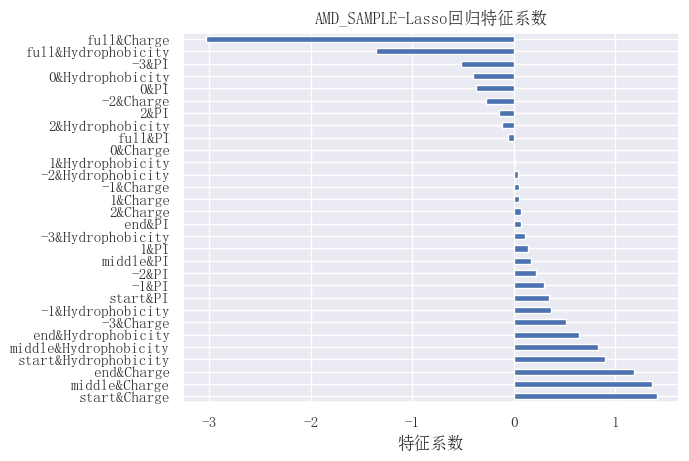

In [10]:
#绘制特征系数图
def feature_importance(lasso):
    # 返回LASSO回归的系数
    dic={'特征':all_df.columns[:-1],'系数':lasso.coef_}
    # df=pd.DataFrame(dic)
    coef = pd.Series(lasso.coef_, all_df.columns[:-1])
    coef=coef.sort_values(ascending=False)
    sns.set(font_scale=1)
    # plt.rc('font', family='Times New Roman')
    plt.rc('font', family='simsun')
    coef.plot(kind="barh")
    plt.xlabel('特征系数')
    plt.title("AMD_SAMPLE-Lasso回归特征系数")
    plt.savefig(r'E:\文件\大学课程\大四上\毕业设计\数据分析\ninthweek\建模\AMD_SAMPLE-Lasso回归特征系数.png',dpi=800)
feature_importance(lasso)

In [11]:
# 按绝对值大小输出所有特征及其对应系数
# coef=coef.abs().sort_values(ascending=False)
sorted_index = coef.abs().argsort()[::-1]
sorted_s = coef.iloc[sorted_index]
sorted_s

full&Charge             -3.037461
start&Charge             1.405134
full&Hydrophobicity     -1.362774
middle&Charge            1.360156
end&Charge               1.185823
start&Hydrophobicity     0.897778
middle&Hydrophobicity    0.831597
end&Hydrophobicity       0.640253
-3&PI                   -0.517326
-3&Charge                0.509838
0&Hydrophobicity        -0.402094
0&PI                    -0.369969
-1&Hydrophobicity        0.363652
start&PI                 0.344675
-1&PI                    0.300584
-2&Charge               -0.278752
-2&PI                    0.213615
middle&PI                0.169697
2&PI                    -0.148380
1&PI                     0.143416
2&Hydrophobicity        -0.118766
-3&Hydrophobicity        0.112501
end&PI                   0.067327
2&Charge                 0.067054
full&PI                 -0.055338
1&Charge                 0.054505
-1&Charge                0.051383
-2&Hydrophobicity        0.045092
1&Hydrophobicity         0.013884
0&Charge      

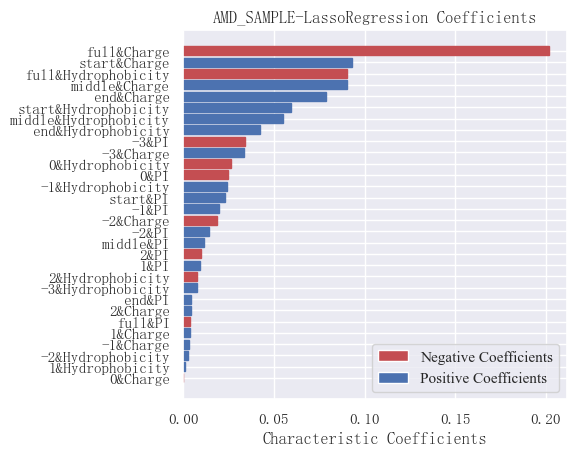

In [12]:
from sklearn.preprocessing import normalize

# 将 sorted_s 转换为二维数组
coef_arr = sorted_s.values.reshape(1, -1)

# 对系数进行归一化
coef_norm = normalize(coef_arr, norm='l1')

# 将归一化后的系数转换为 Series 类型，并设置与 sorted_s 相同的索引
sorted_s_norm = pd.Series(coef_norm.flatten(), index=sorted_s.index)
# sorted_s_norm
# 按特征系数绝对值排序
sorted_s_norm_abs = sorted_s_norm.abs().sort_values(ascending=True)

# lasso特征系数条形图图
fig, ax1 = plt.subplots()
rects = ax1.barh(sorted_s_norm_abs.index, sorted_s_norm_abs.values)
plt.rc('font', family='Times New Roman')
ax1.set_xlabel('Characteristic Coefficients')
ax1.set_title('AMD_SAMPLE-LassoRegression Coefficients')
# 标记原本数值为负的特征系数的柱形图
for i in range(len(rects)):
    if sorted_s_norm[sorted_s_norm_abs.index[i]] < 0:
        rects[i].set_color('r')
    else:
        rects[i].set_color('b')
# 添加图例
red_patch = plt.Rectangle((0, 0), 1, 1, fc='r')
blue_patch=plt.Rectangle((0,1),1,1,fc='b')
ax1.legend([red_patch,blue_patch], ['Negative Coefficients','Positive Coefficients'],loc='lower right')
plt.subplots_adjust(left=0.3)
plt.savefig(r'E:\文件\大学课程\大四上\毕业设计\数据分析\ninthweek\建模\AMD-lasso特征.png',dpi=800)

In [13]:
sorted_s_norm_abs

0&Charge                 0.000107
1&Hydrophobicity         0.000921
-2&Hydrophobicity        0.002992
-1&Charge                0.003410
1&Charge                 0.003617
full&PI                  0.003672
2&Charge                 0.004449
end&PI                   0.004467
-3&Hydrophobicity        0.007465
2&Hydrophobicity         0.007881
1&PI                     0.009516
2&PI                     0.009846
middle&PI                0.011260
-2&PI                    0.014174
-2&Charge                0.018497
-1&PI                    0.019945
start&PI                 0.022871
-1&Hydrophobicity        0.024130
0&PI                     0.024549
0&Hydrophobicity         0.026681
-3&Charge                0.033830
-3&PI                    0.034327
end&Hydrophobicity       0.042484
middle&Hydrophobicity    0.055181
start&Hydrophobicity     0.059572
end&Charge               0.078685
middle&Charge            0.090253
full&Hydrophobicity      0.090427
start&Charge             0.093238
full&Charge   

随机森林模型

In [14]:


# 随机森林模型
# 将y变为离散型
model_data=copy.deepcopy(all_df)
model_data['sig']=0
model_data.loc[model_data['fold-change']>0,'sig']=1
model_data.loc[model_data['fold-change']<0,'sig']=-1

# 拆分自变量和变量
X=copy.deepcopy(model_data.drop('fold-change',axis=1))
X=X.drop('sig',axis=1)
y=copy.deepcopy(model_data['sig'])
#对数据进行归一化
scaler = MinMaxScaler()  # 均值归一化
X_scale=scaler.fit_transform(X)

# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.1,random_state=0)


In [15]:
# 定义参数范围
n_estimators_range = range(1, 301)

# 定义空列表存储每个n_estimators下的平均正确率
aupr_scores = []

# 定义结果记录数组
results = np.zeros((len(n_estimators_range), X.shape[1]))

# 循环遍历参数范围，进行模型拟合和交叉验证
for i,n_estimators in enumerate(n_estimators_range):
    # 定义随机森林分类器
    rf = RandomForestClassifier(n_estimators=n_estimators)
    # 进行10次交叉验证，并计算平均正确率
    scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='average_precision')
    aupr_scores.append(scores.mean())
    # 记录特征重要度
    # rf.fit(x_train, y_train)
    # results[i, :] = rf.feature_importances_




max_aupr= 0.8567035053581564
max_nestimators= 276


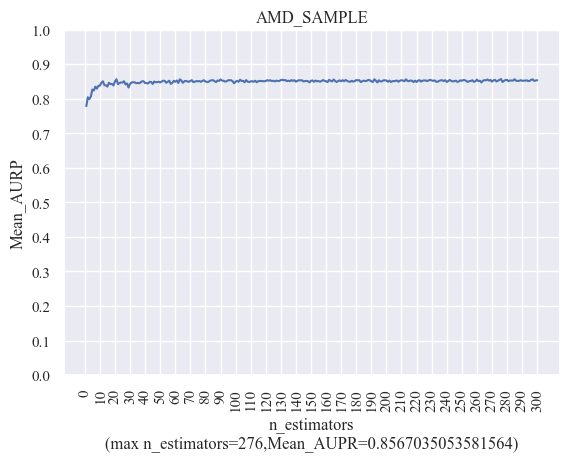

In [16]:
# 设置字体为 Times New Roman
max_estimators=n_estimators_range[np.argmax(aupr_scores)]
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(n_estimators_range,aupr_scores)
plt.xlabel('n_estimators'+'\n'+'(max n_estimators='+str(max_estimators)+','+'Mean_AUPR='+str(max(aupr_scores))+')')
plt.ylabel('Mean_AURP')
plt.title('AMD_SAMPLE')
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(range(0,301,10),rotation=90)
print('max_aupr=',max(aupr_scores))
print('max_nestimators=',n_estimators_range[np.argmax(aupr_scores)])
plt.subplots_adjust(bottom=0.18,top=0.9)
# n_estimators_range[np.argmax(aupr_scores)]
# max(aupr_scores)
plt.savefig(r'E:\文件\大学课程\大四上\毕业设计\数据分析\ninthweek\建模\AMD-随机森林拟合-AUPR.png',dpi=800)

              precision    recall  f1-score   support

          -1       0.68      0.67      0.67        45
           1       0.81      0.82      0.81        76

    accuracy                           0.76       121
   macro avg       0.74      0.74      0.74       121
weighted avg       0.76      0.76      0.76       121



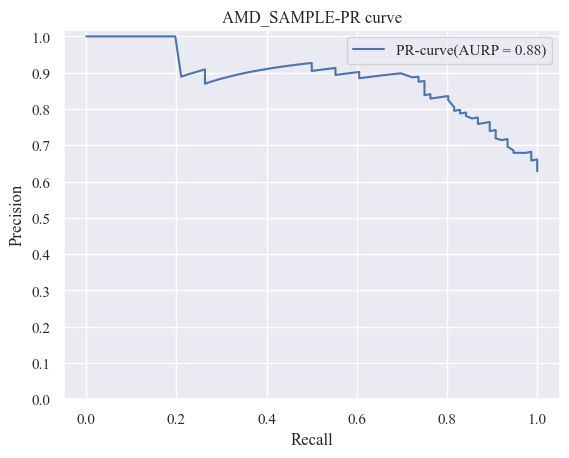

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc


max_estimators=n_estimators_range[np.argmax(aupr_scores)]
#####绘制AUPR曲线#######
rf_model =RandomForestClassifier(n_estimators=max_estimators,random_state=0)
rf_model.fit(x_train, y_train)


# 计算aupr
# 在测试集上进行预测
y_scores = rf_model.predict_proba(x_test)[:, 1]  # 获取正例的预测概率，注意ACT数据正例要调整为-1
# 计算精确率和召回率
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
# 计算AUPR
aupr=auc(recall, precision)

# 输出所有评估指标
y_pred=rf_model.predict(x_test)
print(classification_report(y_test, y_pred))

# 绘制PR-curve曲线
# 设置字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(recall, precision, label='PR-curve(AURP = %0.2f)' % aupr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AMD_SAMPLE-PR curve')
yticks=np.arange(0,1.1,0.1)
plt.yticks(yticks)
plt.legend(loc="upper right")
plt.savefig(r'E:\文件\大学课程\大四上\毕业设计\数据分析\ninthweek\建模\AMD-AUPR.png',dpi=800)

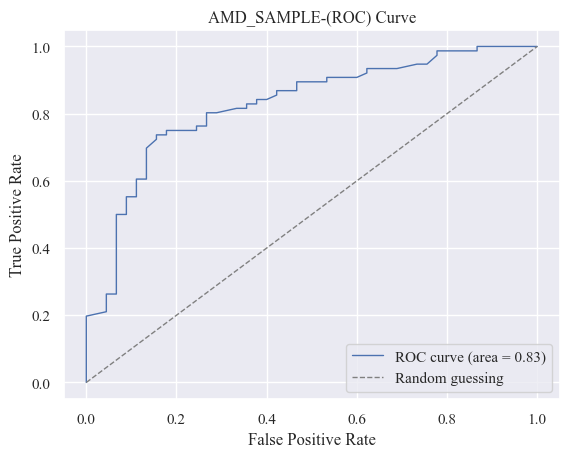

In [26]:
from sklearn.metrics import roc_curve

# 预测测试集结果
y_pred_prob = rf_model.predict_proba(x_test)[:, 1]

# 计算ROC曲线的值
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
# 设置字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1],[0, 1], linestyle='--', lw=1, color='gray',
         label='Random guessing')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AMD_SAMPLE-(ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(r'E:\文件\大学课程\大四上\毕业设计\数据分析\ninthweek\建模\AMD_SAMPLE-(ROC) Curve.png',dpi=800)

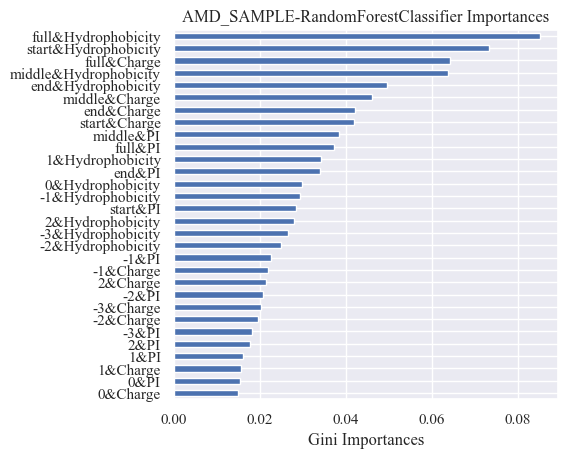

In [18]:
# 提取特征重要性
importances = rf_model.feature_importances_
feature_importance_dict={'Features':X.columns,'Importance':importances}
# 创建 DataFrame 对象
importance_df = pd.DataFrame(feature_importance_dict)
# 按重要度降序排序
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=True)
# 将排序后的特征重要度转换为 Series 对象
importance_series = sorted_importance_df.set_index('Features')['Importance']
# importance_series

# sns.set(font_scale=1)
plt.rc('font', family='Times New Roman')
# plt.rc('font', family='simsun')
importance_series.plot(kind="barh")
plt.ylabel('')
# plt.ylabel('特征')
plt.xlabel('Gini Importances')
plt.title("AMD_SAMPLE-RandomForestClassifier Importances")
plt.subplots_adjust(left=0.3)
plt.savefig(r'E:\文件\大学课程\大四上\毕业设计\数据分析\ninthweek\建模\AMD-随机森林特征.png',dpi=800)

In [19]:
importance_series

Features
0&Charge                 0.014851
0&PI                     0.015373
1&Charge                 0.015660
1&PI                     0.015928
2&PI                     0.017570
-3&PI                    0.018076
-2&Charge                0.019610
-3&Charge                0.020125
-2&PI                    0.020793
2&Charge                 0.021404
-1&Charge                0.021898
-1&PI                    0.022631
-2&Hydrophobicity        0.024894
-3&Hydrophobicity        0.026558
2&Hydrophobicity         0.027854
start&PI                 0.028395
-1&Hydrophobicity        0.029306
0&Hydrophobicity         0.029833
end&PI                   0.033942
1&Hydrophobicity         0.034138
full&PI                  0.037227
middle&PI                0.038374
start&Charge             0.041939
end&Charge               0.042053
middle&Charge            0.046039
end&Hydrophobicity       0.049522
middle&Hydrophobicity    0.063661
full&Charge              0.064095
start&Hydrophobicity     0.073199
full&

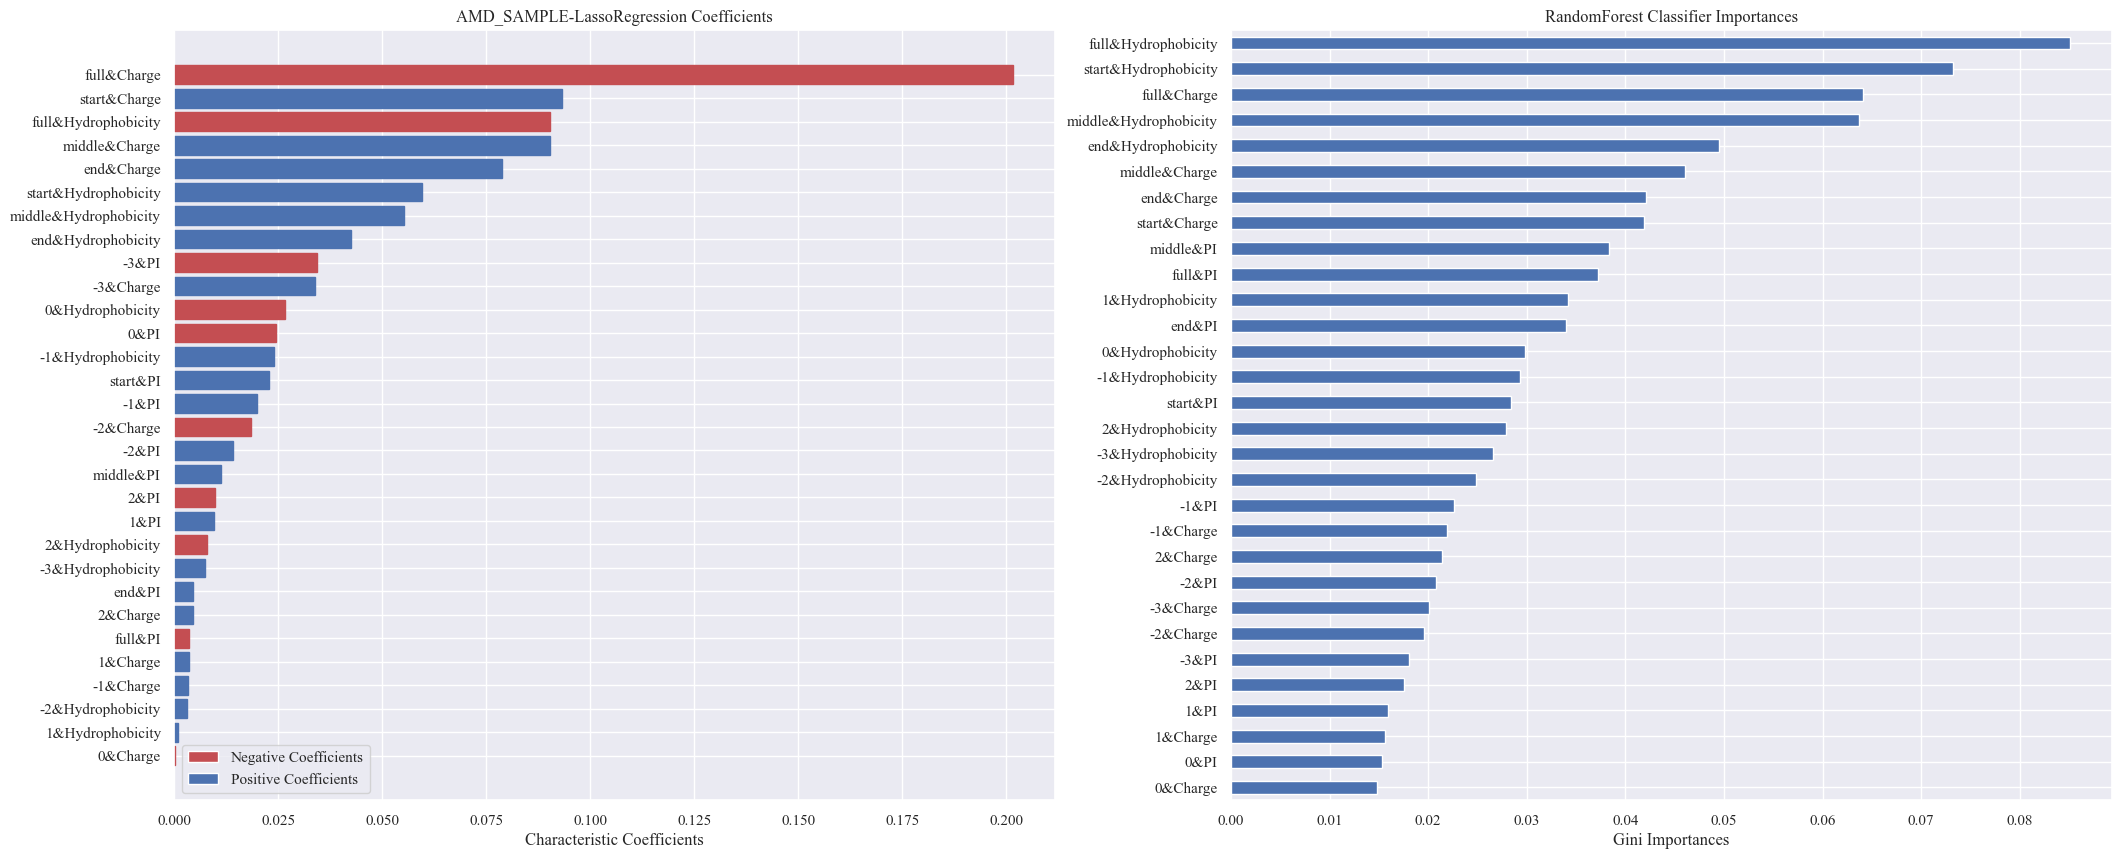

In [20]:
from sklearn.preprocessing import normalize

# 将 sorted_s 转换为二维数组
coef_arr = sorted_s.values.reshape(1, -1)

# 对系数进行归一化
coef_norm = normalize(coef_arr, norm='l1')

# 将归一化后的系数转换为 Series 类型，并设置与 sorted_s 相同的索引
sorted_s_norm = pd.Series(coef_norm.flatten(), index=sorted_s.index)
# sorted_s_norm
# 按特征系数绝对值排序
sorted_s_norm_abs = sorted_s_norm.abs().sort_values(ascending=True)

# lasso特征系数条形图图

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(25, 10))
rects = ax1.barh(sorted_s_norm_abs.index, sorted_s_norm_abs.values)
plt.rc('font', family='Times New Roman')
ax1.set_xlabel('Characteristic Coefficients')
ax1.set_title('AMD_SAMPLE-LassoRegression Coefficients')
# 标记原本数值为负的特征系数的柱形图
for i in range(len(rects)):
    if sorted_s_norm[sorted_s_norm_abs.index[i]] < 0:
        rects[i].set_color('r')
    else:
        rects[i].set_color('b')
# 添加图例
red_patch = plt.Rectangle((0, 0), 1, 1, fc='r')
blue_patch=plt.Rectangle((0,1),1,1,fc='b')
ax1.legend([red_patch,blue_patch], ['Negative Coefficients','Positive Coefficients'])




# 提取特征重要性
importances = rf_model.feature_importances_
feature_importance_dict={'Features':X.columns,'Importance':importances}
# 创建 DataFrame 对象
importance_df = pd.DataFrame(feature_importance_dict)
# 按重要度降序排序
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=True)
# 将排序后的特征重要度转换为 Series 对象
importance_series = sorted_importance_df.set_index('Features')['Importance']
# importance_series

# sns.set(font_scale=1)
# plt.rc('font', family='Times New Roman')
# plt.rc('font', family='simsun')
ax2=importance_series.plot(kind="barh")
ax2.set_ylabel('')
# plt.ylabel('特征')
ax2.set_xlabel('Gini Importances')
ax2.set_title("RandomForest Classifier Importances")
plt.subplots_adjust(hspace=0.8)
# plt.savefig(r'E:\文件\大学课程\大四上\毕业设计\数据分析\ninthweek\建模\AMD重要度分布.png',dpi=800)

Text(0.5, 1.0, 'Random Forest Binary Classification Feature Importance vs n_estimators')

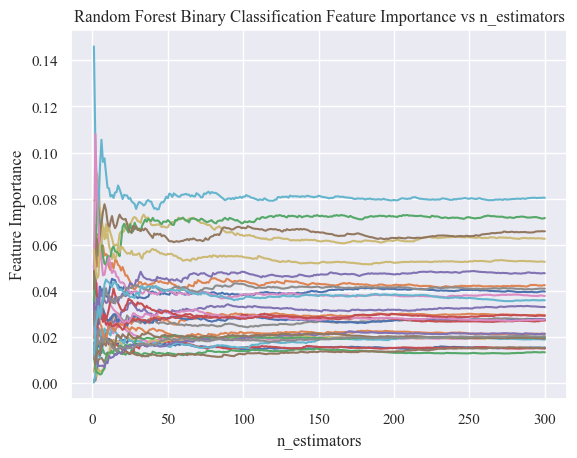

In [21]:
# 定义参数范围
n_estimators_range = range(1, 301)

# 定义结果记录数组
results = np.zeros((len(n_estimators_range), X.shape[1]))

# 循环遍历参数范围
for i, n_estimators in enumerate(n_estimators_range):
    # 构建随机森林分类器
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=123)
    # 训练模型
    clf.fit(x_train, y_train)
    # 记录特征重要度
    results[i, :] = clf.feature_importances_

# 绘制结果图
fig, ax = plt.subplots()

for i in range(X.shape[1]):
    ax.plot(n_estimators_range, results[:, i], label=f"Feature {i+1}")

# 设置图例和标签
# ax.legend()
ax.set_xlabel("n_estimators")
ax.set_ylabel("Feature Importance")
ax.set_title("Random Forest Binary Classification Feature Importance vs n_estimators")

In [22]:
# 将 Series 对象转换为 DataFrame 对象，并重命名列名
df_coef = pd.DataFrame({'Features': sorted_s_norm_abs.index, 'Coefficients': sorted_s_norm_abs.values})
df_importance = pd.DataFrame({'Features': importance_series.index, 'Importances': importance_series.values})

# 合并两个 DataFrame 对象
coef_importance = pd.merge(df_coef, df_importance, on='Features')
coef_importance=coef_importance.sort_values(by='Coefficients',ascending=False)
coef_importance['Coefficients-Importance']=coef_importance['Coefficients']-coef_importance['Importances']
coef_importance

,Features,Coefficients,Importances,Coefficients-Importance
29,full&Charge,0.201551,0.064095,0.137456
28,start&Charge,0.093238,0.041939,0.051299
27,full&Hydrophobicity,0.090427,0.085052,0.005374
26,middle&Charge,0.090253,0.046039,0.044214
25,end&Charge,0.078685,0.042053,0.036632
24,start&Hydrophobicity,0.059572,0.073199,-0.013627
23,middle&Hydrophobicity,0.055181,0.063661,-0.008480
22,end&Hydrophobicity,0.042484,0.049522,-0.007038
21,-3&PI,0.034327,0.018076,0.016252
20,-3&Charge,0.033830,0.020125,0.013706


In [23]:
df_filtered

,sequence,target,stick_terminal,communal-modification,measure,unit,modification1,modification2,activity1,activity2,fold-change,abs(none-modification)
0,ALWKTLLKKVLKA,Staphylococcus aureus B38302,n_terminal,none,MIC,uM,none,AMD,3.00,9.00,-1.584963,6.00
1,ALWKTLLKKVLKA,Escherichia coli U16318,n_terminal,none,MIC,uM,none,AMD,6.00,4.50,0.415037,1.50
5,KKLFKKILKYL,Xanthomonas campestris pv. Vesicatoria 2133-2,n_terminal,none,MIC,uM,none,AMD,15.00,4.65,1.689660,10.35
6,KKLFKKILKYL,Pseudomonas syringae pv. syringae EPS 94,n_terminal,none,MIC,uM,none,AMD,8.75,4.65,0.912052,4.10
7,KKLFKKILKYL,Erwinia amylovora PMV 6076,n_terminal,none,MIC,uM,none,AMD,8.75,4.65,0.912052,4.10
...,...,...,...,...,...,...,...,...,...,...,...,...
3104,TQQAFQKFLAAVTSALGKQYH,Aeromonas hydrophila KCTC 2358,n_terminal,none,MEC,ug/ml,none,AMD,125.00,8.80,3.828281,116.20
3105,TQQAFQKFLAAVTSALGKQYH,Streptococcus iniae FP5229,n_terminal,none,MEC,ug/ml,none,AMD,23.00,4.40,2.386058,18.60
3107,TQQAFQKFLAAVTSALGKQYH,Vibrio parahaemolyticus KCCM 41664,n_terminal,none,MEC,ug/ml,none,AMD,1.50,1.70,-0.180572,0.20
3108,TQQAFQKFLAAVTSALGKQYH,Candida albicans KCTC 7965,n_terminal,none,MEC,ug/ml,none,AMD,12.00,6.20,0.952694,5.80
